# Clustering CD34 image features with PhenoGraph

#### This notebook uses the matrix of 672 features per single cell CD34 channel cropped image to cluster the cells and identify which are leukemia cells based on clustering pattern

## Importing

In [1]:
import warnings
# To ignore Pandas Future Warning
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import scanpy as sc
import pandas as pd
from matplotlib import pyplot as plt
import phenograph
import copy
from scipy import sparse
from sklearn.metrics import adjusted_rand_score
import seaborn as sns
%matplotlib inline

In [2]:
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
print("phenograph==", phenograph.__version__)
sc.settings.set_figure_params(dpi=80, facecolor='white')

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.3 scipy==1.9.1 pandas==1.5.0 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.10.1 pynndescent==0.5.7
phenograph== 1.5.7


In [3]:
from os import listdir
from os.path import isfile, join

In [4]:
pt = 'P53'

### Read in counts tables to obtain raw marker expression per cell

In [5]:
# read in counts tables from each fov
counts_dir = '/data/Zhaolab/1_AMLCosMx/Final_scripts/3_GenerateCounts/' + pt + '_hybrid_counts/'
tables = [f for f in listdir(counts_dir) if isfile(join(counts_dir, f))]
tables.sort()

In [6]:
# create all-fov counts table
all_fovs = pd.read_csv(counts_dir + tables[0], index_col=0, comment='#')

for i in range(1,len(tables)):
    data = pd.read_csv(counts_dir + tables[i], index_col=0, comment='#')
    all_fovs = pd.concat([all_fovs, data])

# add column to sepecify patient
all_fovs['Patient'] = pt
# convert FOV number to 2-digit string
all_fovs['fov'] = all_fovs['fov'].astype(str).str.zfill(2)
all_fovs['cell_ID'] = all_fovs['cell_ID'].astype(int)
all_fovs.head()

fov  cell_ID   x_global_px   y_global_px  x_local_px  y_local_px  z  target  \
0  01        0  51408.022222 -17910.742222     1885.80    3311.480  0   ACTG2   
1  01      722  54182.092222 -18133.138222     4659.87    3089.084  0   ITGAL   
2  01     1122  51700.402222 -18411.142222     2178.18    2811.080  0  WNT10B   
3  01     1127  54433.612222 -18446.172222     4911.39    2776.050  0     FYN   
4  01        0  51163.852222 -18569.889222     1641.63    2652.333  0   NEAT1   

   Size (pixels)   CD298_total  ...    CD45_total    CD45_mean  CD45_median  \
0              0  0.000000e+00  ...  0.000000e+00     0.000000     0.000000   
1           1808  2.667377e+07  ...  1.783167e+06   986.264995   976.111111   
2           1258  1.378964e+07  ...  1.261989e+06  1003.170553   988.888889   
3           2332  2.477784e+07  ...  2.454795e+06  1052.656423   974.833333   
4              0  0.000000e+00  ...  0.000000e+00     0.000000     0.000000   

     CD34_total    CD34_mean  CD34_median     DAPI_total   DAPI_mean  \
0  0.000000e+00     0.000000     0.000000       0.000000    0.000000   
1  2.002051e+06  1107.329216  1080.444444  530252.111111  293.281035   
2  1.351231e+06  1074.110758  1064.277778  231523.555556  184.040982   
3  2.429796e+06  1041.936678  1037.444444  731703.666667  313.766581   
4  0.000000e+00     0.000000     0.000000       0.000000    0.000000   

   DAPI_median  Patient  
0     0.000000      P53  
1   279.222222      P53  
2   164.777778      P53  
3   273.500000      P53  
4     0.000000      P53  

[5 rows x 25 columns]

In [7]:
# create unique ID for each cell (patient + FOV + cell number)
all_fovs['New_ID'] = all_fovs['Patient'] + '_FOV' + all_fovs['fov'] + "_cell_" + all_fovs["cell_ID"].astype(str)
all_fovs

fov  cell_ID   x_global_px   y_global_px  x_local_px  y_local_px  z  \
0         01        0  51408.022222 -17910.742222     1885.80    3311.480  0   
1         01      722  54182.092222 -18133.138222     4659.87    3089.084  0   
2         01     1122  51700.402222 -18411.142222     2178.18    2811.080  0   
3         01     1127  54433.612222 -18446.172222     4911.39    2776.050  0   
4         01        0  51163.852222 -18569.889222     1641.63    2652.333  0   
...       ..      ...           ...           ...         ...         ... ..   
26002726  25        0 -58844.677778  34000.003333     5233.10      16.670  5   
26002727  25     8328 -58831.697778  33996.333333     5246.08      13.000  5   
26002728  25     8328 -58830.077778  33995.453333     5247.70      12.120  6   
26002729  25        0 -58839.657778  33997.863333     5238.12      14.530  6   
26002730  25        0 -58844.437778  34000.103333     5233.34      16.770  6   

           target  Size (pixels)   CD298_total  ...    CD45_mean  CD45_median  \
0           ACTG2              0  0.000000e+00  ...     0.000000     0.000000   
1           ITGAL           1808  2.667377e+07  ...   986.264995   976.111111   
2          WNT10B           1258  1.378964e+07  ...  1003.170553   988.888889   
3             FYN           2332  2.477784e+07  ...  1052.656423   974.833333   
4           NEAT1              0  0.000000e+00  ...     0.000000     0.000000   
...           ...            ...           ...  ...          ...          ...   
26002726  CEACAM6              0  0.000000e+00  ...     0.000000     0.000000   
26002727    CCL21            444  1.901384e+06  ...   691.778779   686.000000   
26002728      LYZ            444  1.901384e+06  ...   691.778779   686.000000   
26002729    CASP8              0  0.000000e+00  ...     0.000000     0.000000   
26002730  CEACAM6              0  0.000000e+00  ...     0.000000     0.000000   

            CD34_total    CD34_mean  CD34_median     DAPI_total   DAPI_mean  \
0         0.000000e+00     0.000000     0.000000       0.000000    0.000000   
1         2.002051e+06  1107.329216  1080.444444  530252.111111  293.281035   
2         1.351231e+06  1074.110758  1064.277778  231523.555556  184.040982   
3         2.429796e+06  1041.936678  1037.444444  731703.666667  313.766581   
4         0.000000e+00     0.000000     0.000000       0.000000    0.000000   
...                ...          ...          ...            ...         ...   
26002726  0.000000e+00     0.000000     0.000000       0.000000    0.000000   
26002727  3.869933e+05   871.606607   865.444444   71647.888889  161.369119   
26002728  3.869933e+05   871.606607   865.444444   71647.888889  161.369119   
26002729  0.000000e+00     0.000000     0.000000       0.000000    0.000000   
26002730  0.000000e+00     0.000000     0.000000       0.000000    0.000000   

          DAPI_median  Patient               New_ID  
0            0.000000      P53     P53_FOV01_cell_0  
1          279.222222      P53   P53_FOV01_cell_722  
2          164.777778      P53  P53_FOV01_cell_1122  
3          273.500000      P53  P53_FOV01_cell_1127  
4            0.000000      P53     P53_FOV01_cell_0  
...               ...      ...                  ...  
26002726     0.000000      P53     P53_FOV25_cell_0  
26002727   165.444444      P53  P53_FOV25_cell_8328  
26002728   165.444444      P53  P53_FOV25_cell_8328  
26002729     0.000000      P53     P53_FOV25_cell_0  
26002730     0.000000      P53     P53_FOV25_cell_0  

[26002731 rows x 26 columns]

In [8]:
# since current table has each row as a transcript read, remove duplicates so we have 1 entry per cell
all_fovs = all_fovs.drop_duplicates(subset='New_ID', keep='first', ignore_index=True)
all_fovs

fov  cell_ID   x_global_px   y_global_px  x_local_px  y_local_px  z  \
0       01        0  51408.022222 -17910.742222    1885.800    3311.480  0   
1       01      722  54182.092222 -18133.138222    4659.870    3089.084  0   
2       01     1122  51700.402222 -18411.142222    2178.180    2811.080  0   
3       01     1127  54433.612222 -18446.172222    4911.390    2776.050  0   
4       01     1642  50567.282222 -18691.882222    1045.060    2530.340  0   
...     ..      ...           ...           ...         ...         ... ..   
144395  25     8325 -59176.017778  33996.953333    4901.760      13.620  1   
144396  25     8322 -58721.017778  33999.493333    5356.760      16.160  3   
144397  25     8326 -63527.552778  33996.853333     550.225      13.520  3   
144398  25     8330 -59441.677778  33995.533333    4636.100      12.200  5   
144399  25     8328 -58825.247778  33994.253333    5252.530      10.920  4   

        target  Size (pixels)   CD298_total  ...    CD45_mean  CD45_median  \
0        ACTG2              0  0.000000e+00  ...     0.000000     0.000000   
1        ITGAL           1808  2.667377e+07  ...   986.264995   976.111111   
2       WNT10B           1258  1.378964e+07  ...  1003.170553   988.888889   
3          FYN           2332  2.477784e+07  ...  1052.656423   974.833333   
4       S100A8           1103  1.088884e+07  ...   903.361036   893.222222   
...        ...            ...           ...  ...          ...          ...   
144395   FGF13            891  4.213225e+06  ...   759.602818   755.666667   
144396    OSMR            629  2.352806e+06  ...   697.942766   688.222222   
144397   IFNL2            615  1.935082e+06  ...   739.311834   735.111111   
144398   ITGB8            584  2.058627e+06  ...   717.734399   714.444444   
144399    C1QB            444  1.901384e+06  ...   691.778779   686.000000   

          CD34_total    CD34_mean  CD34_median     DAPI_total   DAPI_mean  \
0       0.000000e+00     0.000000     0.000000       0.000000    0.000000   
1       2.002051e+06  1107.329216  1080.444444  530252.111111  293.281035   
2       1.351231e+06  1074.110758  1064.277778  231523.555556  184.040982   
3       2.429796e+06  1041.936678  1037.444444  731703.666667  313.766581   
4       1.127601e+06  1022.303616  1018.222222  177244.333333  160.692959   
...              ...          ...          ...            ...         ...   
144395  8.225907e+05   923.221848   914.444444  173241.222222  194.434593   
144396  5.125749e+05   814.904434   817.777778   92997.888889  147.850380   
144397  5.053922e+05   821.775971   822.777778   96947.333333  157.637940   
144398  6.961208e+05  1191.987633   984.888889  102862.333333  176.134132   
144399  3.869933e+05   871.606607   865.444444   71647.888889  161.369119   

        DAPI_median  Patient               New_ID  
0          0.000000      P53     P53_FOV01_cell_0  
1        279.222222      P53   P53_FOV01_cell_722  
2        164.777778      P53  P53_FOV01_cell_1122  
3        273.500000      P53  P53_FOV01_cell_1127  
4        157.888889      P53  P53_FOV01_cell_1642  
...             ...      ...                  ...  
144395   185.444444      P53  P53_FOV25_cell_8325  
144396   140.222222      P53  P53_FOV25_cell_8322  
144397   162.000000      P53  P53_FOV25_cell_8326  
144398   168.444444      P53  P53_FOV25_cell_8330  
144399   165.444444      P53  P53_FOV25_cell_8328  

[144400 rows x 26 columns]

In [9]:
# 0 does not correspond to a real cell, drop from DF
all_fovs_metadata = all_fovs.drop(all_fovs[all_fovs['cell_ID'] == 0].index)

In [10]:
# set unique cell ID as DF index
all_fovs_metadata = all_fovs_metadata.set_index('New_ID')
all_fovs_metadata.head()

fov  cell_ID   x_global_px   y_global_px  x_local_px  \
New_ID                                                                     
P53_FOV01_cell_722   01      722  54182.092222 -18133.138222     4659.87   
P53_FOV01_cell_1122  01     1122  51700.402222 -18411.142222     2178.18   
P53_FOV01_cell_1127  01     1127  54433.612222 -18446.172222     4911.39   
P53_FOV01_cell_1642  01     1642  50567.282222 -18691.882222     1045.06   
P53_FOV01_cell_2038  01     2038  50971.082222 -18922.212222     1448.86   

                     y_local_px  z  target  Size (pixels)   CD298_total  ...  \
New_ID                                                                   ...   
P53_FOV01_cell_722     3089.084  0   ITGAL           1808  2.667377e+07  ...   
P53_FOV01_cell_1122    2811.080  0  WNT10B           1258  1.378964e+07  ...   
P53_FOV01_cell_1127    2776.050  0     FYN           2332  2.477784e+07  ...   
P53_FOV01_cell_1642    2530.340  0  S100A8           1103  1.088884e+07  ...   
P53_FOV01_cell_2038    2300.010  0  ADGRV1           2147  1.542466e+07  ...   

                       CD45_total    CD45_mean  CD45_median    CD34_total  \
New_ID                                                                      
P53_FOV01_cell_722   1.783167e+06   986.264995   976.111111  2.002051e+06   
P53_FOV01_cell_1122  1.261989e+06  1003.170553   988.888889  1.351231e+06   
P53_FOV01_cell_1127  2.454795e+06  1052.656423   974.833333  2.429796e+06   
P53_FOV01_cell_1642  9.964072e+05   903.361036   893.222222  1.127601e+06   
P53_FOV01_cell_2038  2.017848e+06   939.845469   936.888889  2.306407e+06   

                       CD34_mean  CD34_median     DAPI_total   DAPI_mean  \
New_ID                                                                     
P53_FOV01_cell_722   1107.329216  1080.444444  530252.111111  293.281035   
P53_FOV01_cell_1122  1074.110758  1064.277778  231523.555556  184.040982   
P53_FOV01_cell_1127  1041.936678  1037.444444  731703.666667  313.766581   
P53_FOV01_cell_1642  1022.303616  1018.222222  177244.333333  160.692959   
P53_FOV01_cell_2038  1074.246597  1065.555556  358402.666667  166.931843   

                     DAPI_median  Patient  
New_ID                                     
P53_FOV01_cell_722    279.222222      P53  
P53_FOV01_cell_1122   164.777778      P53  
P53_FOV01_cell_1127   273.500000      P53  
P53_FOV01_cell_1642   157.888889      P53  
P53_FOV01_cell_2038   158.111111      P53  

[5 rows x 25 columns]

### Read in feature matrix as csv

In [11]:
# read in features from each fov
feats_dir = 'Normalized_CD34_feats/'
tables = [f for f in listdir(feats_dir) if isfile(join(feats_dir, f))]
tables.sort()

In [12]:
# create all-fov feats table
all_fovs = pd.read_csv(feats_dir + tables[0], index_col=0)

for i in range(1,len(tables)):
    data = pd.read_csv(feats_dir + tables[i], index_col=0)
    all_fovs = pd.concat([all_fovs, data])
    
all_fovs

0         1         2         3         4  \
P53_FOV01_cell_1     0.404822  2.675161  3.191365  2.746427  0.529005   
P53_FOV01_cell_2     0.405687  2.675748  3.190792  2.746643  0.529463   
P53_FOV01_cell_3     0.393460  2.707534  3.190670  2.712938  0.528701   
P53_FOV01_cell_4     0.404828  2.675156  3.191360  2.746430  0.529008   
P53_FOV01_cell_5     0.405405  2.674913  3.190956  2.746605  0.529289   
...                       ...       ...       ...       ...       ...   
P53_FOV25_cell_8326  0.404791  2.675193  3.191385  2.746416  0.528991   
P53_FOV25_cell_8328  0.404791  2.675193  3.191385  2.746416  0.528991   
P53_FOV25_cell_8329  0.404803  2.675182  3.191377  2.746421  0.528996   
P53_FOV25_cell_8330  0.404817  2.674086  3.188040  2.744439  0.530125   
P53_FOV25_cell_8332  0.404791  2.675193  3.191385  2.746416  0.528991   

                            5         6         7         8         9  ...  \
P53_FOV01_cell_1     0.363455  2.389140 -0.162254  0.791265  0.274640  ...   
P53_FOV01_cell_2     0.363033  2.388447 -0.162167  0.791297  0.274703  ...   
P53_FOV01_cell_3     0.362855  2.368962 -0.156068  0.795674  0.275665  ...   
P53_FOV01_cell_4     0.363456  2.389138 -0.162254  0.791267  0.274640  ...   
P53_FOV01_cell_5     0.363396  2.388916 -0.162225  0.791359  0.274617  ...   
...                       ...       ...       ...       ...       ...  ...   
P53_FOV25_cell_8326  0.363455  2.389145 -0.162254  0.791262  0.274641  ...   
P53_FOV25_cell_8328  0.363455  2.389145 -0.162254  0.791262  0.274641  ...   
P53_FOV25_cell_8329  0.363456  2.389143 -0.162254  0.791264  0.274641  ...   
P53_FOV25_cell_8330  0.362932  2.387035 -0.161124  0.791706  0.276065  ...   
P53_FOV25_cell_8332  0.363455  2.389145 -0.162254  0.791262  0.274641  ...   

                          662       663       664       665       666  \
P53_FOV01_cell_1     0.533260 -0.050054  0.060124 -0.030627  1.726231   
P53_FOV01_cell_2     0.534490 -0.050218  0.059572 -0.030447  1.725372   
P53_FOV01_cell_3     0.513295 -0.040807  0.129411 -0.024097  1.738873   
P53_FOV01_cell_4     0.533272 -0.050054  0.060123 -0.030628  1.726225   
P53_FOV01_cell_5     0.534119 -0.050157  0.059836 -0.030627  1.725722   
...                       ...       ...       ...       ...       ...   
P53_FOV25_cell_8326  0.533214 -0.050049  0.060137 -0.030625  1.726255   
P53_FOV25_cell_8328  0.533214 -0.050049  0.060137 -0.030625  1.726255   
P53_FOV25_cell_8329  0.533232 -0.050050  0.060131 -0.030625  1.726246   
P53_FOV25_cell_8330  0.535396 -0.048736  0.060632 -0.029882  1.725238   
P53_FOV25_cell_8332  0.533214 -0.050049  0.060137 -0.030625  1.726255   

                          667       668       669       670       671  
P53_FOV01_cell_1     0.147960  3.446983 -0.079172  0.620769 -0.041413  
P53_FOV01_cell_2     0.148162  3.447612 -0.078264  0.622029 -0.041688  
P53_FOV01_cell_3     0.144478  3.453350 -0.091365  0.587205 -0.033105  
P53_FOV01_cell_4     0.147962  3.446985 -0.079161  0.620778 -0.041415  
P53_FOV01_cell_5     0.148127  3.447340 -0.078368  0.621764 -0.041503  
...                       ...       ...       ...       ...       ...  
P53_FOV25_cell_8326  0.147950  3.446966 -0.079220  0.620732 -0.041409  
P53_FOV25_cell_8328  0.147950  3.446966 -0.079220  0.620732 -0.041409  
P53_FOV25_cell_8329  0.147954  3.446971 -0.079201  0.620748 -0.041410  
P53_FOV25_cell_8330  0.148455  3.446574 -0.078622  0.624981 -0.042242  
P53_FOV25_cell_8332  0.147950  3.446966 -0.079220  0.620732 -0.041409  

[144976 rows x 672 columns]

In [13]:
# concatenate individual FOV feature tables as 1 large feature table
all_fovs.to_csv(pt + "_all_cell_CD34_features.csv", header=False)

In [14]:
# read in feature matrix as anndata object for clustering
adata = sc.read_csv(pt + "_all_cell_CD34_features.csv", first_column_names=True)
adata

AnnData object with n_obs × n_vars = 144976 × 672

In [15]:
adata.obs

Empty DataFrame
Columns: []
Index: [P53_FOV01_cell_1, P53_FOV01_cell_2, P53_FOV01_cell_3, P53_FOV01_cell_4, P53_FOV01_cell_5, P53_FOV01_cell_6, P53_FOV01_cell_7, P53_FOV01_cell_8, P53_FOV01_cell_9, P53_FOV01_cell_10, P53_FOV01_cell_11, P53_FOV01_cell_12, P53_FOV01_cell_13, P53_FOV01_cell_14, P53_FOV01_cell_15, P53_FOV01_cell_16, P53_FOV01_cell_17, P53_FOV01_cell_18, P53_FOV01_cell_19, P53_FOV01_cell_20, P53_FOV01_cell_21, P53_FOV01_cell_22, P53_FOV01_cell_23, P53_FOV01_cell_24, P53_FOV01_cell_25, P53_FOV01_cell_26, P53_FOV01_cell_27, P53_FOV01_cell_28, P53_FOV01_cell_29, P53_FOV01_cell_30, P53_FOV01_cell_31, P53_FOV01_cell_32, P53_FOV01_cell_33, P53_FOV01_cell_34, P53_FOV01_cell_35, P53_FOV01_cell_36, P53_FOV01_cell_37, P53_FOV01_cell_38, P53_FOV01_cell_39, P53_FOV01_cell_40, P53_FOV01_cell_41, P53_FOV01_cell_42, P53_FOV01_cell_43, P53_FOV01_cell_44, P53_FOV01_cell_45, P53_FOV01_cell_46, P53_FOV01_cell_47, P53_FOV01_cell_48, P53_FOV01_cell_49, P53_FOV01_cell_50, P53_FOV01_cell_51, P53_FOV01_cell_52, P53_FOV01_cell_53, P53_FOV01_cell_54, P53_FOV01_cell_55, P53_FOV01_cell_56, P53_FOV01_cell_57, P53_FOV01_cell_58, P53_FOV01_cell_59, P53_FOV01_cell_60, P53_FOV01_cell_61, P53_FOV01_cell_62, P53_FOV01_cell_63, P53_FOV01_cell_64, P53_FOV01_cell_65, P53_FOV01_cell_66, P53_FOV01_cell_67, P53_FOV01_cell_68, P53_FOV01_cell_69, P53_FOV01_cell_70, P53_FOV01_cell_71, P53_FOV01_cell_72, P53_FOV01_cell_73, P53_FOV01_cell_74, P53_FOV01_cell_75, P53_FOV01_cell_76, P53_FOV01_cell_77, P53_FOV01_cell_78, P53_FOV01_cell_79, P53_FOV01_cell_80, P53_FOV01_cell_81, P53_FOV01_cell_82, P53_FOV01_cell_83, P53_FOV01_cell_84, P53_FOV01_cell_85, P53_FOV01_cell_86, P53_FOV01_cell_87, P53_FOV01_cell_88, P53_FOV01_cell_89, P53_FOV01_cell_90, P53_FOV01_cell_91, P53_FOV01_cell_92, P53_FOV01_cell_93, P53_FOV01_cell_94, P53_FOV01_cell_95, P53_FOV01_cell_96, P53_FOV01_cell_97, P53_FOV01_cell_98, P53_FOV01_cell_99, P53_FOV01_cell_100, ...]

[144976 rows x 0 columns]

In [16]:
# load FOV metadata
FOV_metadata = pd.read_csv('/data/Zhaolab/1_AMLCosMx/Final_scripts/4_CellTyping/FOV_metadata.csv', index_col=0)
FOV_metadata

Timepoint Clinical outcome
P51_FOV01         A               PD
P51_FOV02         A               PD
P51_FOV03         A               PD
P51_FOV04         A               PD
P51_FOV05         A               PD
...             ...              ...
P58_FOV19         C               SD
P58_FOV20         C               SD
P58_FOV21         C               SD
P58_FOV22         C               SD
P58_FOV23         C               SD

[141 rows x 2 columns]

In [17]:
# get FOV and cell number from cell ID, timepoint from csv file

adata.obs['FOV'] = ''
adata.obs['cell_ID'] = 0
adata.obs['Timepoint'] = ''

for i in range(adata.obs.shape[0]):
    adata.obs['FOV'].iloc[i] = adata.obs.iloc[i].name[7:9]
    adata.obs['cell_ID'].iloc[i] = adata.obs.iloc[i].name[15:].replace('.png', '')
    adata.obs['Timepoint'].iloc[i] = FOV_metadata['Timepoint'].loc[adata.obs.iloc[i].name[0:9]]

adata.obs

/tmp/ipykernel_2195509/3782544952.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['FOV'].iloc[i] = adata.obs.iloc[i].name[7:9]
/tmp/ipykernel_2195509/3782544952.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['cell_ID'].iloc[i] = adata.obs.iloc[i].name[15:].replace('.png', '')


FOV cell_ID Timepoint
P53_FOV01_cell_1     01       1         A
P53_FOV01_cell_2     01       2         A
P53_FOV01_cell_3     01       3         A
P53_FOV01_cell_4     01       4         A
P53_FOV01_cell_5     01       5         A
...                  ..     ...       ...
P53_FOV25_cell_8326  25    8326         C
P53_FOV25_cell_8328  25    8328         C
P53_FOV25_cell_8329  25    8329         C
P53_FOV25_cell_8330  25    8330         C
P53_FOV25_cell_8332  25    8332         C

[144976 rows x 3 columns]

### Map protein expression values to appropriate cell IDs in feature table

In [18]:
adata.obs = adata.obs.merge(all_fovs_metadata[['Size (pixels)', 'CD34_median']], how='left', left_index=True, right_index=True)
adata.obs

FOV cell_ID Timepoint  Size (pixels)  CD34_median
P53_FOV01_cell_1     01       1         A          474.0   903.111111
P53_FOV01_cell_2     01       2         A         1609.0   954.333333
P53_FOV01_cell_3     01       3         A         1951.0   932.666667
P53_FOV01_cell_4     01       4         A          961.0   890.888889
P53_FOV01_cell_5     01       5         A         2401.0   908.666667
...                  ..     ...       ...            ...          ...
P53_FOV25_cell_8326  25    8326         C          615.0   822.777778
P53_FOV25_cell_8328  25    8328         C          444.0   865.444444
P53_FOV25_cell_8329  25    8329         C          392.0  1060.833333
P53_FOV25_cell_8330  25    8330         C          584.0   984.888889
P53_FOV25_cell_8332  25    8332         C            NaN          NaN

[144976 rows x 5 columns]

### Remove cells classified as RBCs or not passing size filter

In [19]:
# read in list of cells that passed RBC & size filter
RBCs = pd.read_csv('/data/Zhaolab/1_AMLCosMx/Final_scripts/4_CellTyping/2_FilterbySize/Cells_filtbyRBCandsize.csv', index_col=0)
ptRBCs = RBCs[RBCs['Patient'] == pt]
ptRBCs['Passed_QC'] = 1

/tmp/ipykernel_2195509/310710571.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ptRBCs['Passed_QC'] = 1


In [20]:
adata.obs = adata.obs.merge(ptRBCs['Passed_QC'], how='left', left_index=True, right_index=True)
adata

AnnData object with n_obs × n_vars = 144976 × 672
    obs: 'FOV', 'cell_ID', 'Timepoint', 'Size (pixels)', 'CD34_median', 'Passed_QC'

In [21]:
adata = adata[adata.obs['Passed_QC'] == 1]
adata

View of AnnData object with n_obs × n_vars = 139989 × 672
    obs: 'FOV', 'cell_ID', 'Timepoint', 'Size (pixels)', 'CD34_median', 'Passed_QC'

## Pre-Processing

### Log-Transformation

In [22]:
#Log-transform our dataset using the default Scanpy utility
adata_log1p = sc.pp.log1p(adata, copy = True)

### Principal Component Analysis (PCA)

In [23]:
#adata = adata_log1p # don't use log-scaled dataset
adata = sc.tl.pca(adata, n_comps = 50, copy = True)

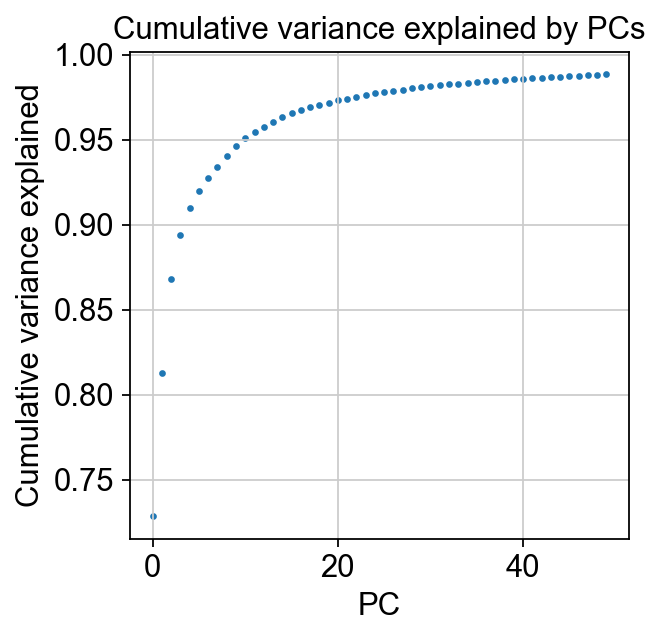

In [24]:
# Cumulative variance explained:
cml_var_explained = np.cumsum(adata.uns['pca']['variance_ratio'])
x = range(len(adata.uns['pca']['variance_ratio']))
y = cml_var_explained
plt.scatter(x, y, s=4)
plt.xlabel('PC')
plt.ylabel('Cumulative variance explained')
plt.title('Cumulative variance explained by PCs')
plt.show()

In [25]:
# set the minimum cumulative fraction of variance explained
min_cml_frac = 0.20
# find the number of PCs that together explain the minimal cum. fraction of variance
n_pcs = next(idx for idx,cml_frac in enumerate(cml_var_explained) if cml_frac > min_cml_frac)
print('Number of PCs that together explain a fraction of ' + str(min_cml_frac) + ' of the variance: ' + str(n_pcs))

Number of PCs that together explain a fraction of 0.2 of the variance: 0


## Clustering with PhenoGraph

### Running PhenoGraph

In [26]:
k = 25 # choose k, smaller values for finer-grained clustering
sc.settings.verbose = 0
communities, graph, Q = phenograph.cluster(pd.DataFrame(adata.obsm['X_pca']),k=k) # run PhenoGraph
# store the results in adata:
adata.obs['PhenoGraph_clusters'] = pd.Categorical(communities)
adata.uns['PhenoGraph_Q'] = Q
adata.uns['PhenoGraph_k'] = k

Finding 25 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 782.3373413085938 seconds
Jaccard graph constructed in 80.14796948432922 seconds
Wrote graph to binary file in 2.995820999145508 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.942478
After 10 runs, maximum modularity is Q = 0.943505
Louvain completed 30 runs in 180.59758925437927 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 1085.162778377533 seconds


In [27]:
# run clustering
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


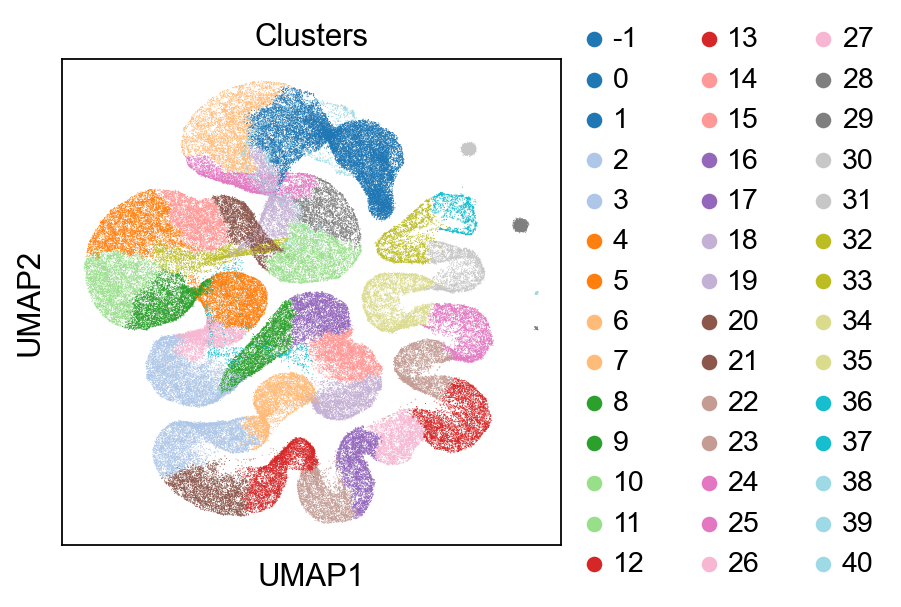

In [28]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"]
)

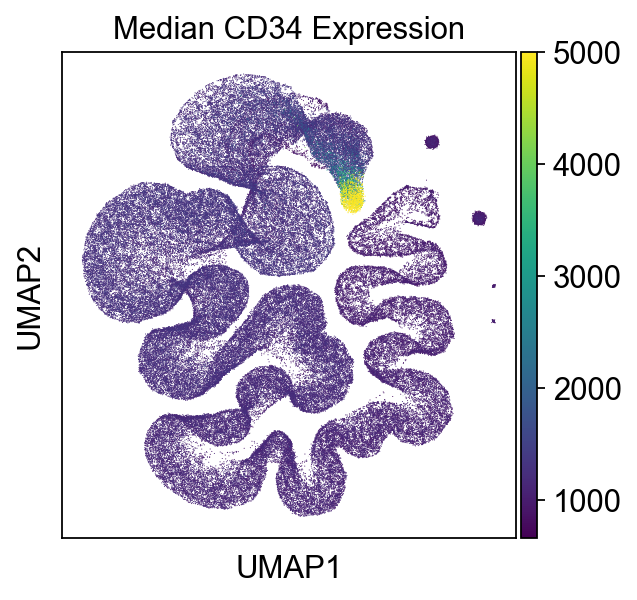

In [29]:
sc.pl.umap(
    adata, 
    color=['CD34_median'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["Median CD34 Expression"],
    vmax=5000
)

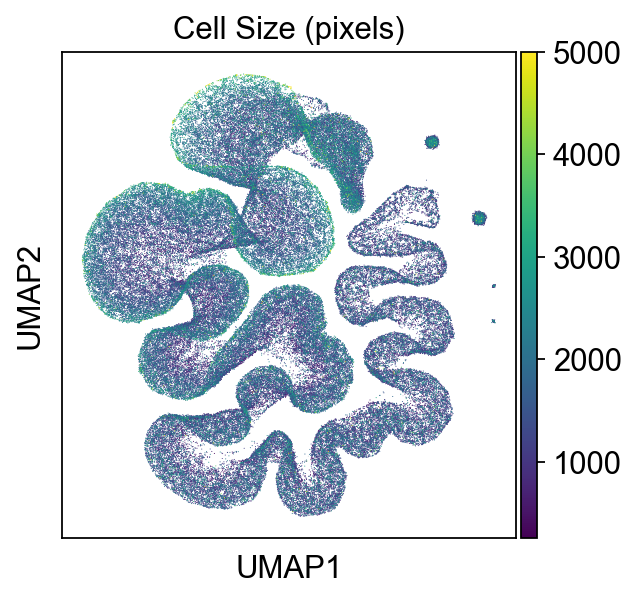

In [30]:
sc.pl.umap(
    adata, 
    color=['Size (pixels)'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["Cell Size (pixels)"],
    vmax=5000
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


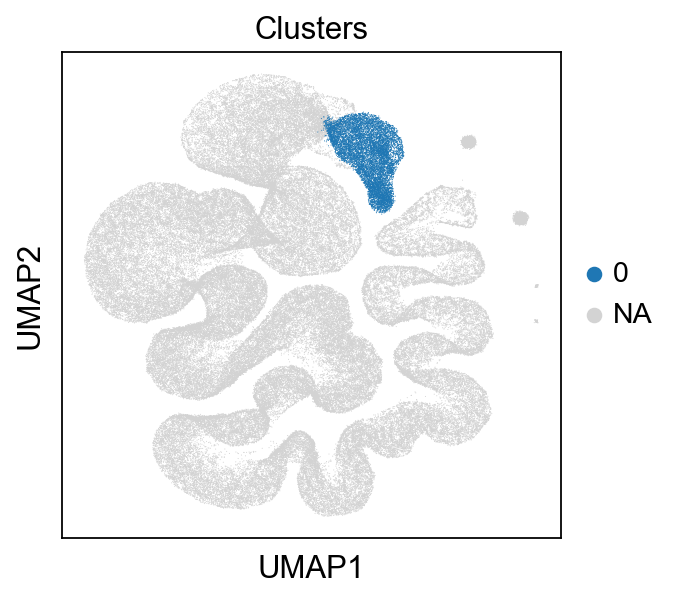

In [31]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"], groups=[0]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


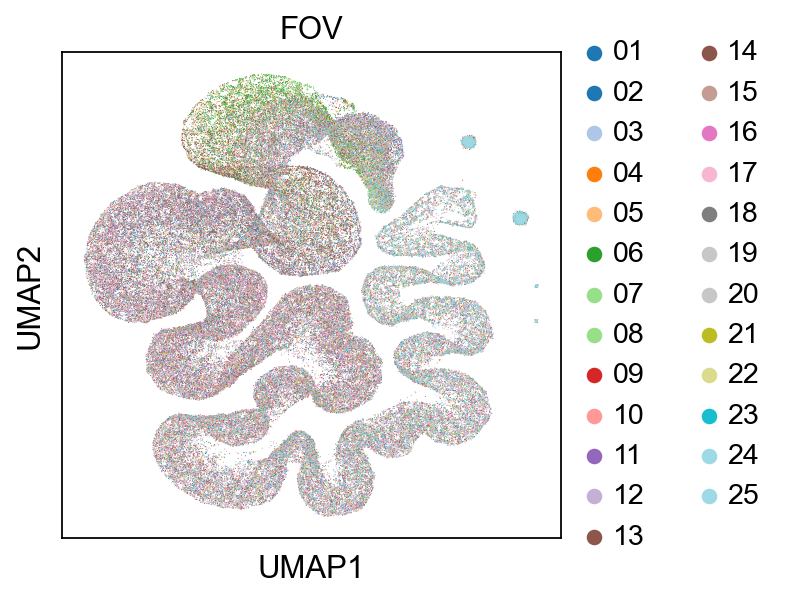

In [32]:
sc.pl.umap(
    adata, 
    color=['FOV'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["FOV"]
)

In [33]:
# save dataframe of clustering results (adata.obs)
adata.obs.to_csv(pt + '_CD34_clusters.csv')

In [34]:
adata_all = adata

In [35]:
# save clustered data anndata object
adata_all.write_h5ad(pt + '_CD34_cell_features_clustered.h5ad')

## Sub-cluster CD34+ candidates (cluster 0)

In [36]:
adata = adata[adata.obs['PhenoGraph_clusters'].isin([0])]
adata.obs = adata.obs.rename(columns={"PhenoGraph_clusters": "PhenoGraph_clusters_round_1"})
adata

AnnData object with n_obs × n_vars = 9922 × 672
    obs: 'FOV', 'cell_ID', 'Timepoint', 'Size (pixels)', 'CD34_median', 'Passed_QC', 'PhenoGraph_clusters_round_1'
    uns: 'pca', 'PhenoGraph_Q', 'PhenoGraph_k', 'neighbors', 'umap', 'PhenoGraph_clusters_colors', 'FOV_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## Pre-Processing

### Log-Transformation

In [37]:
#Log-transform our dataset using the default Scanpy utility
adata_log1p = sc.pp.log1p(adata, copy = True)

### Principal Component Analysis (PCA)

In [38]:
#adata = adata_log1p # don't use log-scaled dataset
adata = sc.tl.pca(adata, n_comps = 50, copy = True)

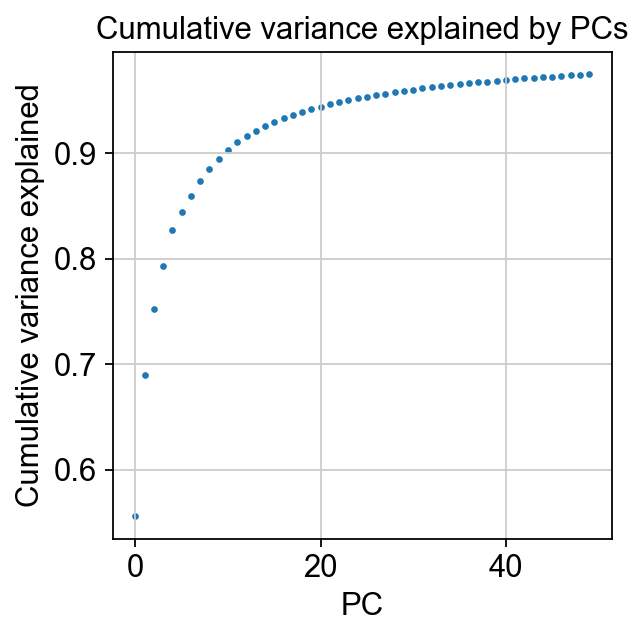

In [39]:
# Cumulative variance explained:
cml_var_explained = np.cumsum(adata.uns['pca']['variance_ratio'])
x = range(len(adata.uns['pca']['variance_ratio']))
y = cml_var_explained
plt.scatter(x, y, s=4)
plt.xlabel('PC')
plt.ylabel('Cumulative variance explained')
plt.title('Cumulative variance explained by PCs')
plt.show()

In [40]:
# set the minimum cumulative fraction of variance explained
min_cml_frac = 0.20
# find the number of PCs that together explain the minimal cum. fraction of variance
n_pcs = next(idx for idx,cml_frac in enumerate(cml_var_explained) if cml_frac > min_cml_frac)
print('Number of PCs that together explain a fraction of ' + str(min_cml_frac) + ' of the variance: ' + str(n_pcs))

Number of PCs that together explain a fraction of 0.2 of the variance: 0


## Clustering with PhenoGraph

### Running PhenoGraph

In [41]:
k = 25 # choose k, smaller values for finer-grained clustering
sc.settings.verbose = 0
communities, graph, Q = phenograph.cluster(pd.DataFrame(adata.obsm['X_pca']),k=k) # run PhenoGraph
# store the results in adata:
adata.obs['PhenoGraph_clusters'] = pd.Categorical(communities)
adata.uns['PhenoGraph_Q'] = Q
adata.uns['PhenoGraph_k'] = k

Finding 25 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.7137084007263184 seconds
Jaccard graph constructed in 41.80470585823059 seconds
Wrote graph to binary file in 0.2976572513580322 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.782704
After 2 runs, maximum modularity is Q = 0.786209
Louvain completed 22 runs in 4.86240816116333 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 89.44404983520508 seconds


In [42]:
# run clustering
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)

In [5]:
# load adata
adata = sc.read_h5ad(pt + '_CD34_cell_features_subclustered.h5ad')

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


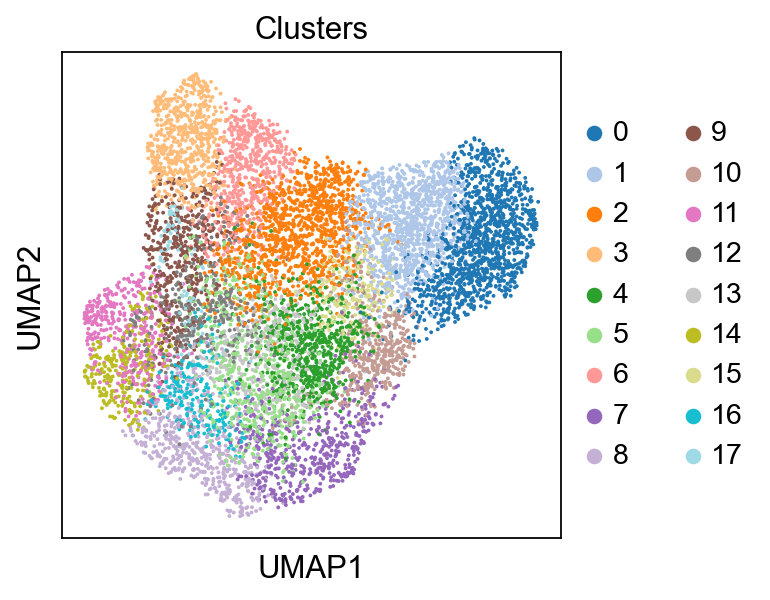

In [6]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


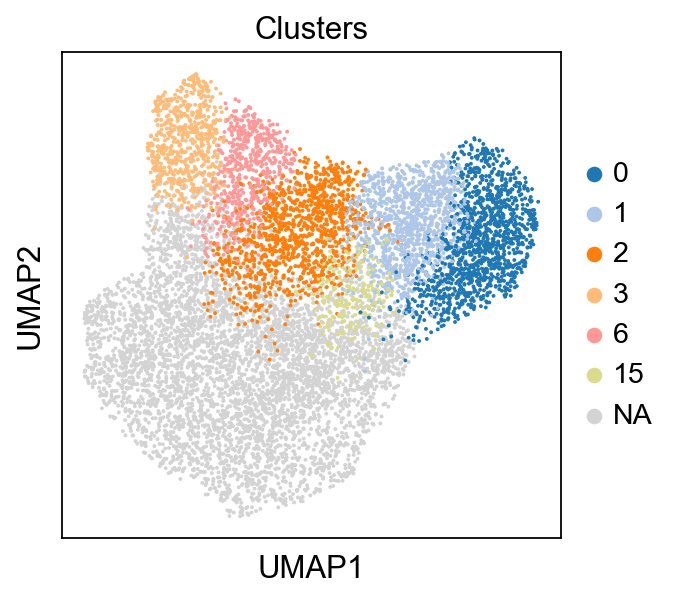

In [14]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"], groups=[0,1,2,3,6,15]
)

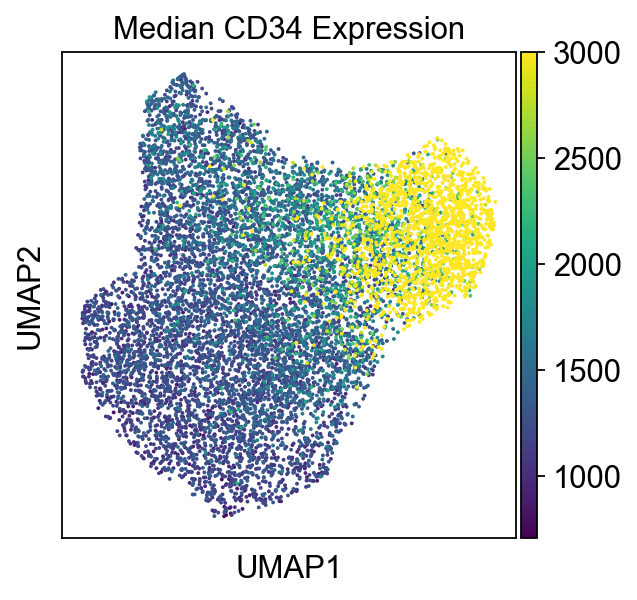

In [8]:
sc.pl.umap(
    adata, 
    color=['CD34_median'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["Median CD34 Expression"],
    vmax=3000
)

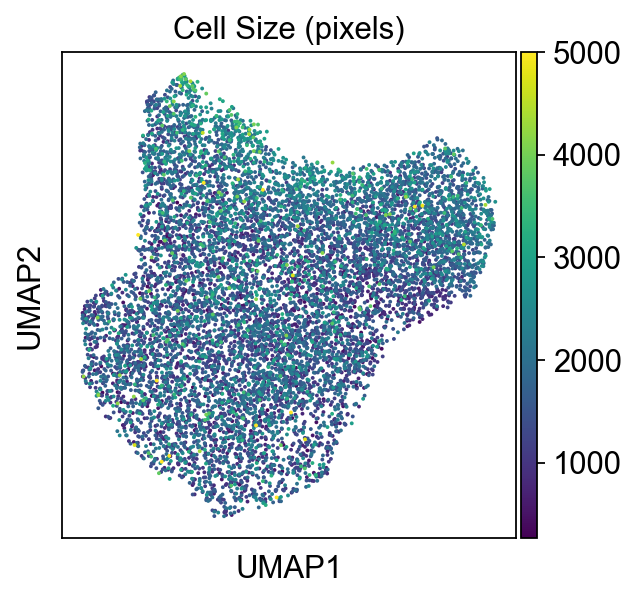

In [48]:
sc.pl.umap(
    adata, 
    color=['Size (pixels)'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["Cell Size (pixels)"],
    vmax=5000
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


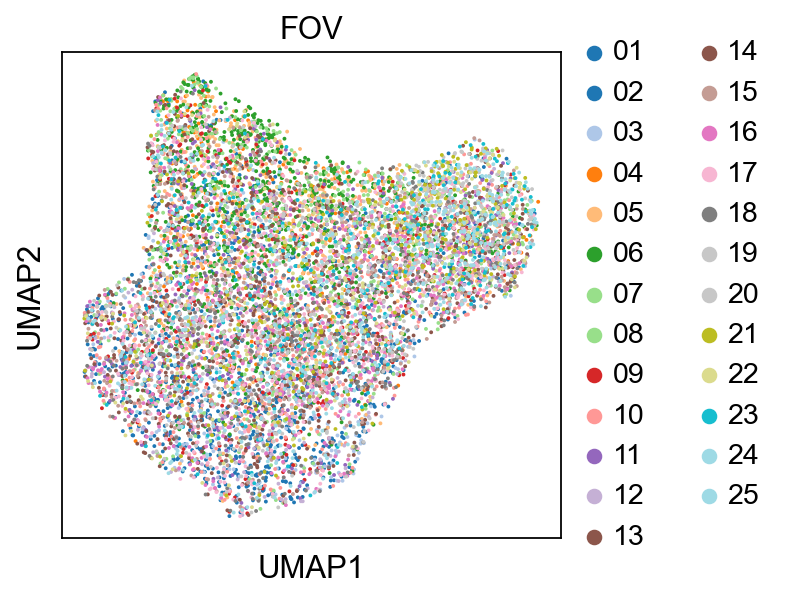

In [50]:
sc.pl.umap(
    adata, 
    color=['FOV'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["FOV"]
)

In [51]:
# save dataframe of clustering results (adata.obs)
adata.obs.to_csv(pt + '_CD34_subclusters.csv')

In [52]:
# save clustered data anndata object
adata.write_h5ad(pt + '_CD34_cell_features_subclustered.h5ad')